In [135]:
#필요한 라이브러리 import

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns



In [136]:
#review_file에 데이터 파일 경로를 지정해 csv파일을 df에 저장한다.

review_file = './amazon_uk_shoes_products_dataset_2021_12.csv'
df = pd.read_csv(review_file)


In [137]:
#필요없는 열 삭제한다.
df.drop(columns=['url', 'product_name', 'reviewer_name', 'verified_purchase', 'review_date', 'helpful_count', 'uniq_id', 'scraped_at'], inplace=True)

#결측값이 있는 행을 삭제한다.
df.dropna(subset=['review_text'], inplace=True)

#삭제가 잘 됐는지 확인한다.
display(df)

,review_title,review_text,review_rating
0,Love em,Love these. Was looking for converses and thes...,5.0
1,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0
2,Good quality,Good quality,5.0
3,Good,Great,5.0
4,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0
...,...,...,...
6818,Schick und leicht,"Schicker Schuh, läuft sich gut.",5.0
6819,EXCELLENT,Mieux que je ne l'imaginais. Très bonne taille...,5.0
6820,Einfach schöne Hausschuhe,Habe sie als Geschenk gekauft und sie sind seh...,5.0
6821,Langlebig.,Trage diese Hausschuhe fast zwei Monate jeden ...,5.0


In [146]:
#일관성을 위해 리뷰텍스트를 소문자로 변환한다.

df['review_text'] = df['review_text'].str.lower()

display(df)


,review_title,review_text,review_rating,cleaned_review_text
0,Love em,love these. was looking for converses and thes...,5.0,love look convers half price unique— ’ never s...
1,The plastic ripped,"the shoes are very cute, but after the 2nd day...",2.0,shoe cute 2nd day wear tongu start rip 3rd day...
2,Good quality,good quality,5.0,good qualiti
3,Good,great,5.0,great
4,PERFETTE!!,ho scelto il modello bianco con rifinitura die...,5.0,ho scelto il modello bianco con rifinitura die...
...,...,...,...,...
6818,Schick und leicht,"schicker schuh, läuft sich gut.",5.0,schicker schuh läuft sich gut
6819,EXCELLENT,mieux que je ne l'imaginais. très bonne taille...,5.0,mieux que je ne limaginai trè bonn taill bonn ...
6820,Einfach schöne Hausschuhe,habe sie als geschenk gekauft und sie sind seh...,5.0,habe sie al geschenk gekauft und sie sind sehr...
6821,Langlebig.,trage diese hausschuhe fast zwei monate jeden ...,5.0,trage dies hausschuh fast zwei monat jeden tag...


In [147]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#불용어 리스트를 가져오고 어간 객체 초기화
stop_words = set(stopwords.words('english'))
pst = PorterStemmer()  #어간 추출
wnl = WordNetLemmatizer() #표제어 추출


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [148]:
#스테밍 전처리 함수

def preprocess_text(text):
    #문자열의 구두점 제거
    text = text.translate(str.maketrans('', '', string.punctuation))

    words = word_tokenize(text)  #텍스트를 단어 단위로 토큰화
    
    #불용어 제거 
    words = [word for word in words if word not in stop_words]
    
    #porterstemmer로 처리
    words = [pst.stem(word) for word in words]
    
    return ' '.join(words)


In [149]:
#스테밍한 리뷰텍스트를 클린텍스트 리뷰에 저장하고 확인

df['cleaned_review_text'] = df['review_text'].apply(preprocess_text)

display(df)


,review_title,review_text,review_rating,cleaned_review_text
0,Love em,love these. was looking for converses and thes...,5.0,love look convers half price unique— ’ never s...
1,The plastic ripped,"the shoes are very cute, but after the 2nd day...",2.0,shoe cute 2nd day wear tongu start rip 3rd day...
2,Good quality,good quality,5.0,good qualiti
3,Good,great,5.0,great
4,PERFETTE!!,ho scelto il modello bianco con rifinitura die...,5.0,ho scelto il modello bianco con rifinitura die...
...,...,...,...,...
6818,Schick und leicht,"schicker schuh, läuft sich gut.",5.0,schicker schuh läuft sich gut
6819,EXCELLENT,mieux que je ne l'imaginais. très bonne taille...,5.0,mieux que je ne limaginai trè bonn taill bonn ...
6820,Einfach schöne Hausschuhe,habe sie als geschenk gekauft und sie sind seh...,5.0,habe sie al geschenk gekauft und sie sind sehr...
6821,Langlebig.,trage diese hausschuhe fast zwei monate jeden ...,5.0,trage dies hausschuh fast zwei monat jeden tag...


In [150]:
# 데이터 분할
X = df['cleaned_review_text']
y = df['review_rating'].apply(lambda x: 1 if x > 3 else 0)  # 평점이 4 이상이면 긍정(1), 아니면 부정(0)

#데이터를 학습, 테스트셋으로 분할하고 테스트 사이즈는 전체 데이터의 40%로 지정, 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [151]:
# 텍스트 데이터를 벡터화하고 fit_transform은 학습셋 벡터라이저를 학습하고 변환 transform은 테스트셋을 변환
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 모델을 학습하고 평가
review_model = LogisticRegression()
review_model.fit(X_train_vec, y_train)
y_pred = review_model.predict(X_test_vec)


# 성능을 평가
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.54      0.63       676
           1       0.86      0.94      0.90      2050

    accuracy                           0.84      2726
   macro avg       0.80      0.74      0.76      2726
weighted avg       0.83      0.84      0.83      2726



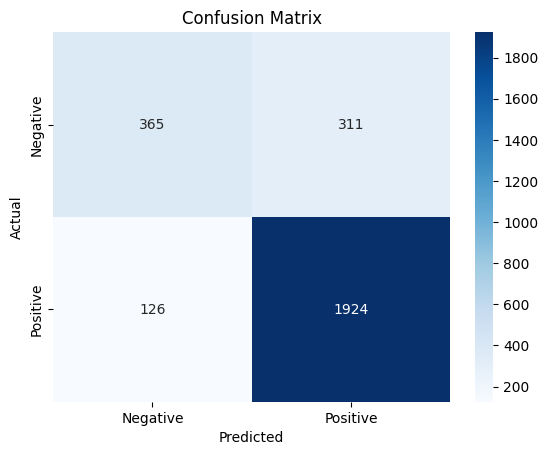

In [152]:
# 혼동행렬을 시각화하기
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


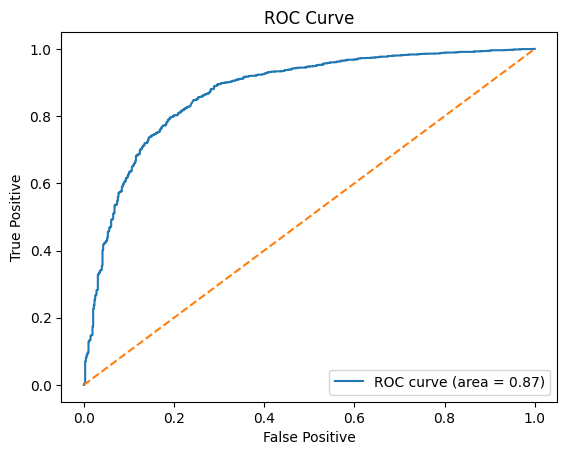

In [145]:
# ROC 곡선 및 AUC 점수를 시각화
y_pred_prob = review_model.predict_proba(X_test_vec)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
